In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt

import dataloader
import bandpower

# Extract stress from excel

In [2]:
df = pd.read_csv('./data/SFC_DASS21.csv')
df.head()

,session,semester,subject,depression,anxiety,stress
0,'20140922_s1',1,1,18,20,38
1,'20141103_s1+s2',1,1,28,28,30
2,'20141201_s1+s2',1,1,34,34,32
3,'20141215_s1+s2',1,1,26,24,22
4,'20141229_s1+s2',1,1,36,26,30


In [3]:
df['stress'].describe()

count    171.000000
mean       7.450292
std        8.510315
min        0.000000
25%        0.000000
50%        4.000000
75%       12.000000
max       38.000000
Name: stress, dtype: float64

In [4]:
df[df['subject']<19]

,session,semester,subject,depression,anxiety,stress
0,'20140922_s1',1,1,18,20,38
1,'20141103_s1+s2',1,1,28,28,30
2,'20141201_s1+s2',1,1,34,34,32
3,'20141215_s1+s2',1,1,26,24,22
4,'20141229_s1+s2',1,1,36,26,30
...,...,...,...,...,...,...
89,'20141002_s17+s18',1,18,2,2,0
90,'20141023_s17+s18',1,18,0,2,0
91,'20141127_s17+s18',1,18,2,4,4
92,'20141211_s17+s18',1,18,2,2,0


In [8]:
# Get increased stress or normal label for each subject
num_sub = 26
group_mean = df.groupby(by='subject').mean()
labels = []

for i in range(len(df)):
    stress_sub = df.iloc[i]['stress']
    sub = df.iloc[i]['subject']
    threshold = group_mean.loc[sub]['stress']
    
    labels.append(stress_sub>threshold)
    
labels = np.asarray(labels, 'int')
df['label'] = labels
print('Label 1: %d, Label 0: %d'%(np.sum(labels), len(labels)-np.sum(labels)))

Label 1: 58, Label 0: 113


In [9]:
df.head()

,session,semester,subject,depression,anxiety,stress,label
0,'20140922_s1',1,1,18,20,38,1
1,'20141103_s1+s2',1,1,28,28,30,0
2,'20141201_s1+s2',1,1,34,34,32,1
3,'20141215_s1+s2',1,1,26,24,22,0
4,'20141229_s1+s2',1,1,36,26,30,0


## Extract EEG data from mat files

In [14]:
A, B, C = dataloader.read_data()

Load data from .mat files...


In [25]:
channels = sio.loadmat('./data/ch_lib.mat')
df = pd.DataFrame(columns = ['ID'] + list(range(30)))

for i in range(len(channels['ch_lib'])):
    channels_i = channels['ch_lib'][i][0][0]
    channels_select_i = [channels_i[i][0] for i in range(len(channels_i))]
    num_channel_i = len(channels_select_i)
    df.loc[i] = [i+1] + list(channels_select_i) + ['None']*(30-num_channel_i)
    

In [26]:
df

,ID,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,1,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
1,2,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
2,3,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
3,4,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8,None
4,5,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,PZ,T3,T4,T5,T6,TP7,TP8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,167,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8
167,168,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8
168,169,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8
169,170,C3,C4,CP3,CP4,CPZ,CZ,F3,F4,F7,...,OZ,P3,P4,P7,P8,PZ,T7,T8,TP7,TP8


In [6]:
channels_i = channels['ch_lib'][0][0][0]
channels_select_i = [channels_i[i][0] for i in range(len(channels_i))]
channels_select_i

['C3',
 'C4',
 'CP3',
 'CP4',
 'CPZ',
 'CZ',
 'F3',
 'F4',
 'F7',
 'F8',
 'FC3',
 'FC4',
 'FCZ',
 'FP1',
 'FP2',
 'FT7',
 'FT8',
 'FZ',
 'O1',
 'O2',
 'OZ',
 'P3',
 'P4',
 'PZ',
 'T3',
 'T4',
 'T5',
 'T6',
 'TP7',
 'TP8']

In [4]:
dataloader.find_common_channels()

['C4', 'CP3', 'CP4', 'F7', 'F8', 'FC4', 'FZ', 'P3']

# Extract DSS Stress level

In [57]:
subjects = list(range(1,27))
df_subs = pd.DataFrame()

for subject in subjects:
    if subject <= 18:
        file_path = './data/DSS/first semester/%s/first_datebystress%d.txt'%(str(subject).zfill(2), subject)
    else:
        file_path = './data/DSS/second semester/%s/second_datebystress%d.txt'%(str(subject-18).zfill(2), subject-18)

    df = pd.read_csv(file_path, sep = '\s+', header=0, names=['date','stress'], index_col=False)
    df['subject'] = [subject]*len(df)
    df_subs = df_subs.append(df)
    
df_subs = df_subs.reset_index(drop=True)

# Run t-test for resting spectrum between increase and normal stress

In [92]:
EEG_list, labels, df_all = dataloader.read_data(label_format=2)

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [93]:
low, high = list(range(1,50)), list(range(2,51))
powers = bandpower.get_bandpower(EEG_list, 500, low, high)

Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 2.496e+02 2.498e+02 2.500e+02]
Shape of psd:  (30, 1251)


In [86]:
# Plot psd of each trial
freqs = range(1,50)
for i in range(len(powers)):
    plt.figure()
    for j in range(powers[i].shape[0]):
        plt.plot(freqs,10*np.log10(powers[i][j,:]))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB)')
    plt.title('PSD of No.%d trial'%(i))
    plt.savefig('./results/%d.png'%(i))
    plt.close()
    

In [94]:
increase_group, normal_group = [], []

# Seperate two groups and average over channels
for i, power in enumerate(powers):
    
    # Average over channels
    avg = np.mean(power, axis=0)
    
    
    # Transform to dB
    avg = 10 * np.log10(avg)
    
    
    if labels[i] == 1:
        increase_group.append(avg)
    else:
        normal_group.append(avg)
        
increase_group = np.array(increase_group)
normal_group = np.array(normal_group)

In [95]:
mean_inc, std_inc = np.mean(increase_group, axis=0), np.std(increase_group, axis=0)
mean_nor, std_nor = np.mean(normal_group, axis=0), np.std(normal_group, axis=0)

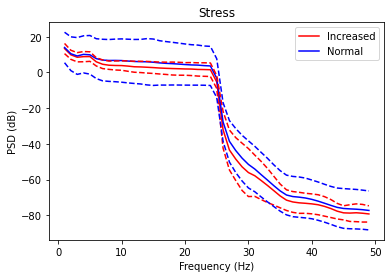

In [96]:
freqs = range(1,50)
plt.plot(freqs, mean_inc, 'r-', label='Increased')
plt.plot(freqs, mean_nor, 'b-', label='Normal')
plt.plot(freqs, mean_inc+std_inc, 'r--', freqs, mean_inc-std_inc, 'r--')
plt.plot(freqs, mean_nor+std_nor, 'b--', freqs, mean_nor-std_nor, 'b--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('Stress')
plt.legend()
plt.savefig('./results/PSD_label2.png')

In [97]:
ttest_result = stats.ttest_ind(increase_group, normal_group)

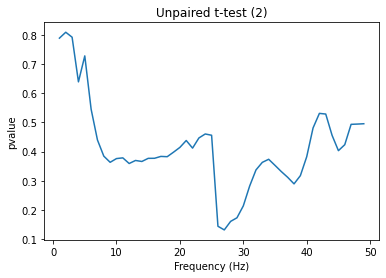

In [98]:
plt.plot(freqs, ttest_result.pvalue)
plt.xlabel('Frequency (Hz)')
plt.ylabel('pvalue')
plt.title('Unpaired t-test (2)')
plt.savefig('./results/t-test_label2.png')

# Compare labels based on three criteria

In [3]:
labels = {}
for i in range(1,4):
    _, Y, _ = dataloader.read_data(label_format=i)
    labels['Label%d'%(i)] = Y
    
df = pd.DataFrame(labels)
df.to_csv('./results/labels.csv')

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
